# 라이브러리 호출

In [1]:
from importlib.metadata import version
import cv2
import pixellib

import os
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# 이미지 확인

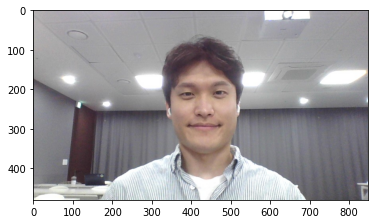

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 인물(피사체) 세그멘테이션

In [3]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [4]:
segvalues, output = model.segmentAsPascalvoc(img_path)

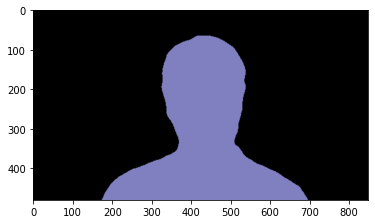

In [5]:
plt.imshow(output)
plt.show()

In [6]:
seg_color = (128,128,192)

(480, 848)


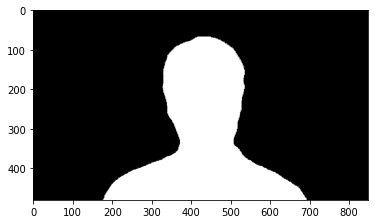

In [7]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

# 오리지날 이미지와 배경 overlapping

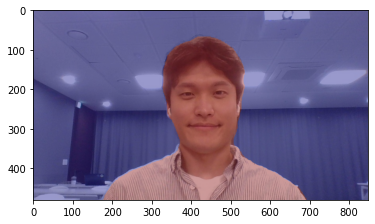

In [8]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 배경 블러처리

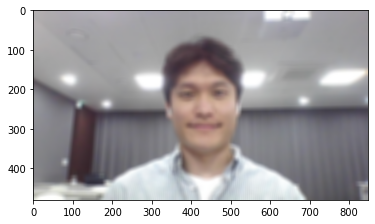

In [9]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 인물 제외하고 블러처리

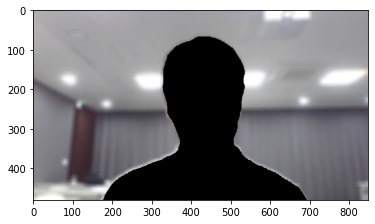

In [10]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 인물과 블러배경 합성

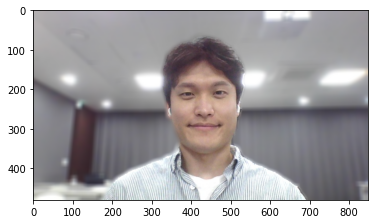

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 배경 블러 및 크로마키 함수화

In [2]:
def blurring(img_path, model_file, background = None):
    
    # 이미지 불러오기
    img_orig = cv2.imread(img_path) 
        
    # 모델 불러오기
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)

    segvalues, output = model.segmentAsPascalvoc(img_path)

    seg_color = (128,128,192)

    seg_map = np.all(output==seg_color, axis=-1)

    img_show = img_orig.copy()

    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255

    # 255와 0을 적당한 색상으로 바꿔봅니다
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # 원본 이미지와 마스트를 적당히 합쳐봅니다
    # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

    # (13,13)은 blurring kernel size를 뜻합니다
    # 다양하게 바꿔보세요
    img_orig_blur = cv2.blur(img_orig, (13,13))  

    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    
    
    img_bg_blur = cv2.imread(background) 

    img_bg_resized = cv2.resize( img_bg_blur, (img_orig.shape[1], img_orig.shape[0]) )

    img_concat2 = np.where(img_mask_color == 255, img_orig, img_bg_resized)

    fig = plt.figure(dpi=150)
    
    fig.set_size_inches(13.5, 11.5, forward=True)
    rows = 1
    cols = 3

    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    ax1.set_title('Normal')
    ax1.axis("off")

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    ax2.set_title('Blurred')
    ax2.axis("off")

    ax3 = fig.add_subplot(rows, cols, 3)
    ax3.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
    ax3.set_title('Backgroud')
    ax3.axis("off")
    
    filename = os.path.basename(img_path)[:-4]
    save_dir = os.getenv('HOME')+'/aiffel/human_segmentation/images/'
    
    extent1 = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig( save_dir + filename + '_blurred.png', bbox_inches=extent1, dpi = 150)
    
    extent2 = ax3.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig( save_dir + filename + '_background.png', bbox_inches=extent2, dpi = 150)
    
    plt.show()

# 다양한 이미지 불러오기

In [3]:
my_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png' 
ryn_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/ryujin.jpg' 
sugar_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sugar.jpg' 
bts_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bts.jpg' 
forest_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/forest.jpg' 

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# 다양한 이미지에 블러&크로마키 적용하기

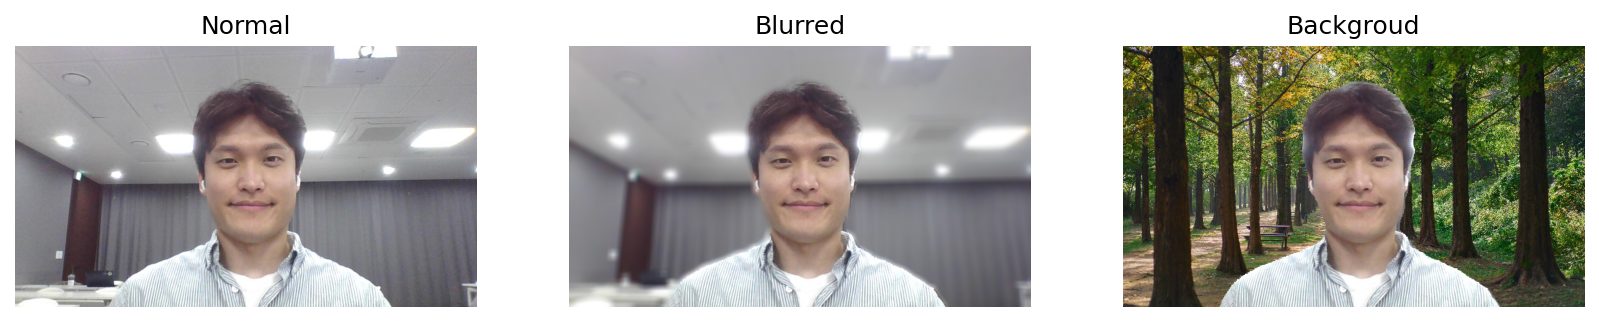

In [15]:
blurring(my_img_path, model_file, forest_img_path)

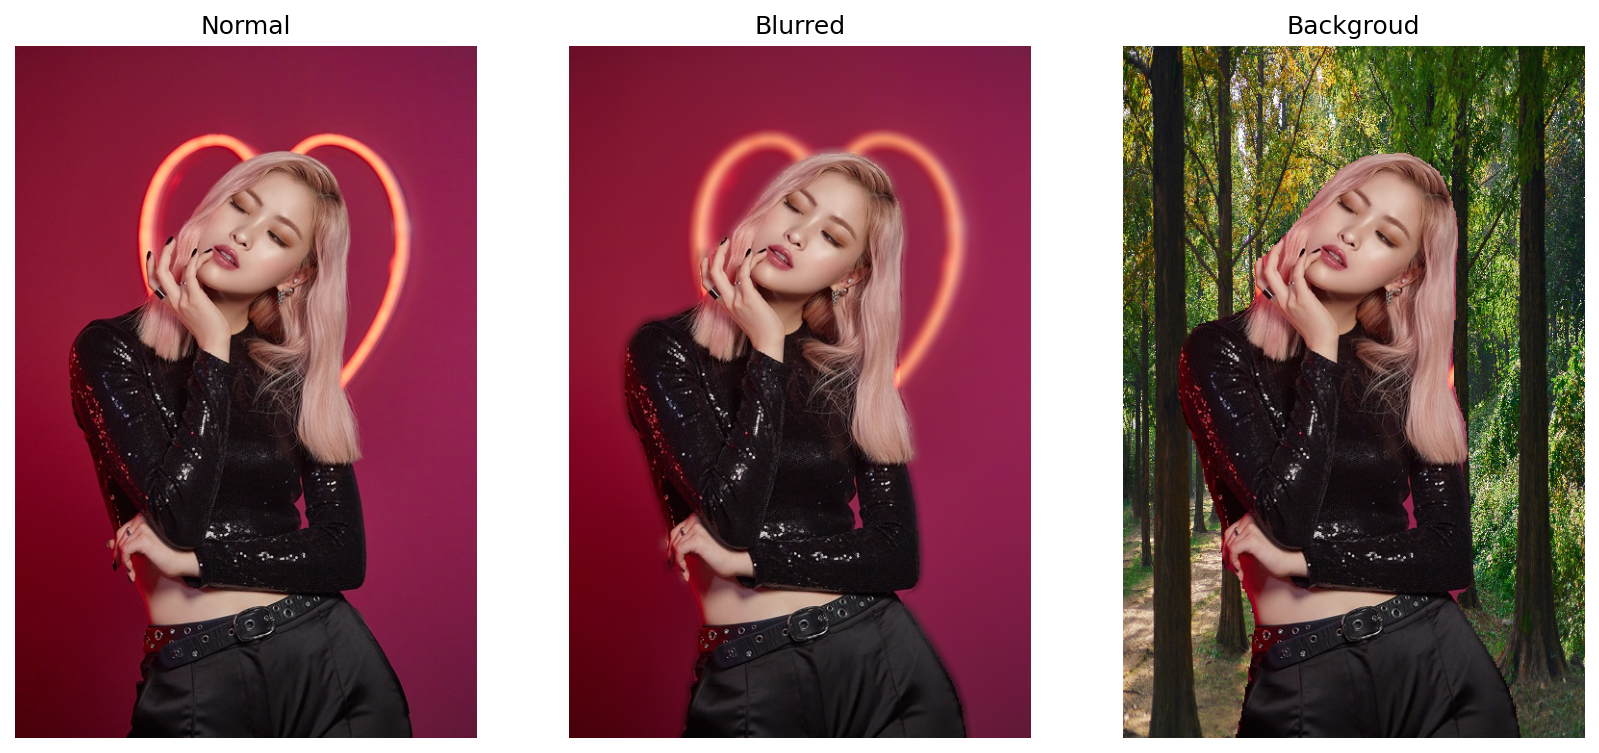

In [16]:
blurring(ryn_img_path, model_file, forest_img_path)

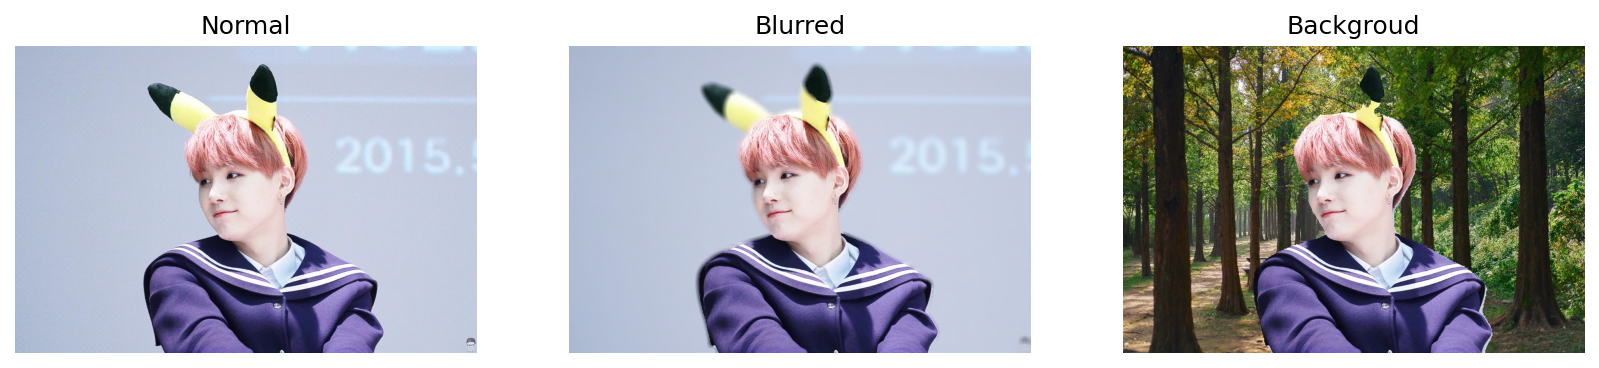

In [17]:
blurring(sugar_img_path, model_file, forest_img_path)

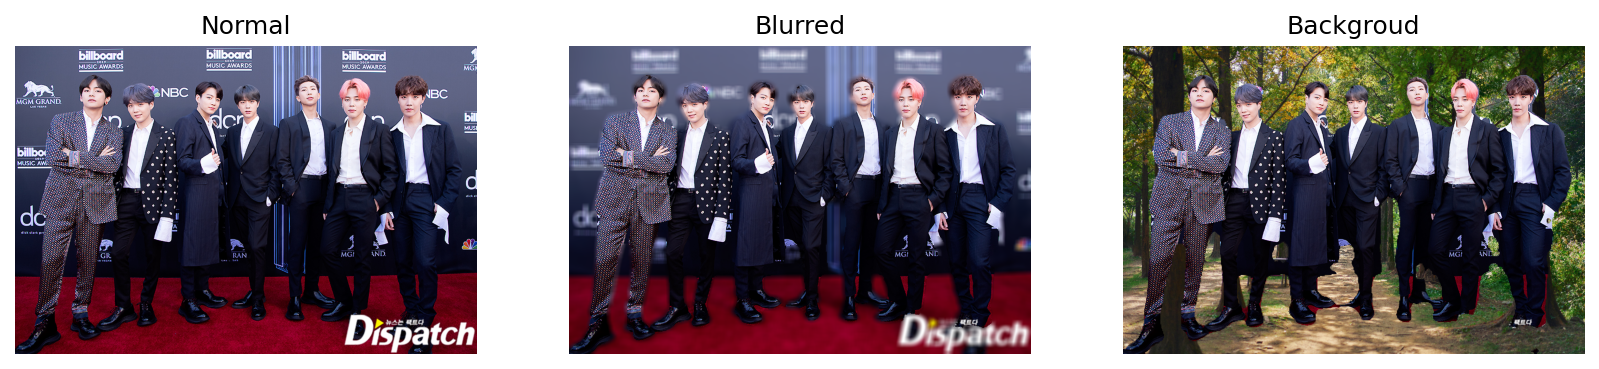

In [4]:
blurring(bts_img_path, model_file, forest_img_path)

# 문제점 찾기

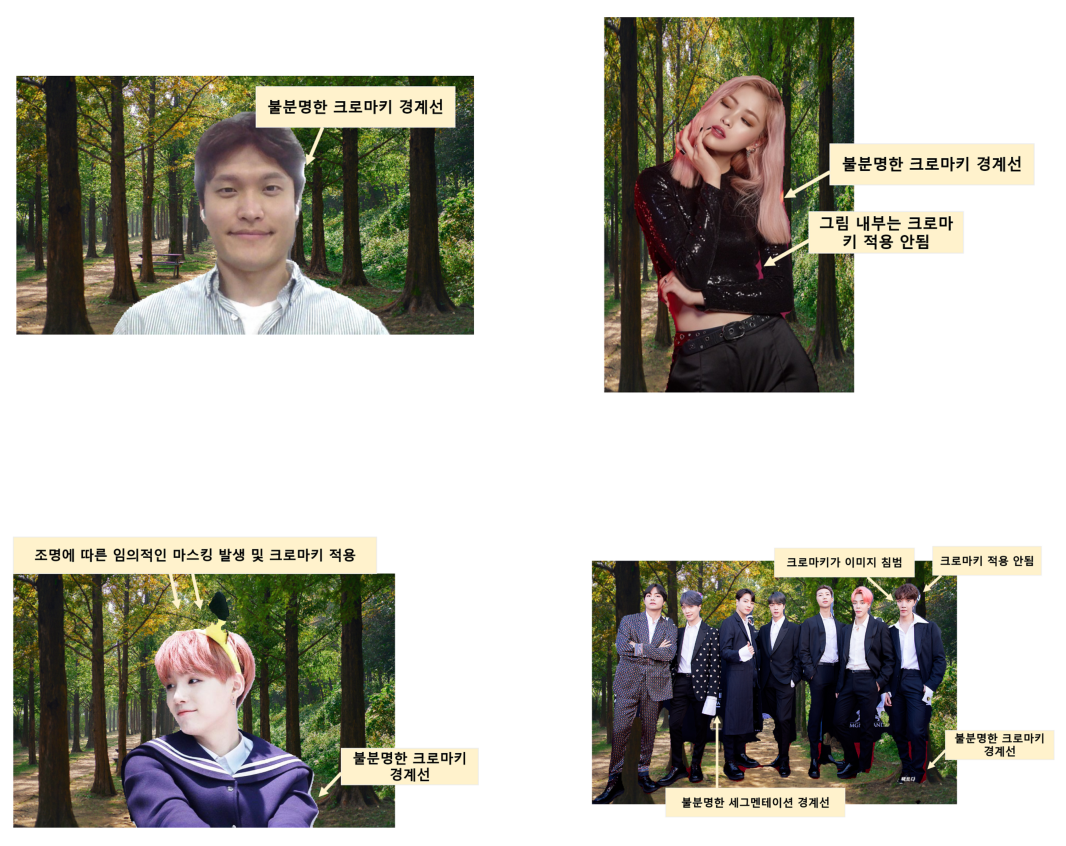

In [20]:
img_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/그림1.png'
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/그림2.png'
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/그림3.png'
img_path4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/그림4.png'

img_orig1 = cv2.imread(img_path1)
img_orig2 = cv2.imread(img_path2)
img_orig3 = cv2.imread(img_path3)
img_orig4 = cv2.imread(img_path4)

fig = plt.figure(dpi=100)
fig.set_size_inches(13.5, 11.5, forward=True)

ax1 = fig.add_subplot(221)
ax1.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
ax1.axis("off")

ax1 = fig.add_subplot(222)
ax1.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
ax1.axis("off")

ax1 = fig.add_subplot(223)
ax1.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
ax1.axis("off")

ax1 = fig.add_subplot(224)
ax1.imshow(cv2.cvtColor(img_orig4, cv2.COLOR_BGR2RGB))
ax1.axis("off")

plt.show()

# 회고

1. 인물모드 사진을 성공적으로 제작  
  **내 사진과 연예인 두 명 그리고 연예인 단체 사진에, blur처리와 크로마키 변환을 시도**  
2. 제작한 인물모드 사진들에서 나타나는 문제점을 지적  
  **이미지에 마스킹, 불분명한 마스킹 경계선, 불분명한 세그멘테이션 경계선 확인**  
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션 제시  
  **최근에 모두팝 세미나 강의에서 적대적 생성신경망, GAN(Generative Adversarial Network)을 모티브해서 안개 이미지에서 안개를 선명한 이미지로 세그멘테이션하는 모델링 방법이 있다는 것을 들었는데, 그것을 적용해보면 어떨까. GAN의 freeze 방법을 적용해서, 같은 세그멘테이션끼리의 픽셀 벡터들은 거리가 가까워지도록 학습하고, 배경 및 다른 세그멘테이션 픽셀 벡터는 거리가 멀어지도록 학습해서, 세그멘테이션과 배경을, 나아가서 특정 세그멘테이션과 다른 세그멘테이션을 잘 구분하는 모델링 방법을 사용한다면 세그멘테이션 정확도를 높일 수 있을 것으로 기대한다.**  

# Reference

1. https://blog.daum.net/geoscience/1263
2. https://github.com/JaeHeee/AIFFEL_Project/blob/master/EXPLORATION/EXPLORATION%2014.%20%EC%9D%B8%EB%AC%BC%EC%82%AC%EC%A7%84%EC%9D%84%20%EB%A7%8C%EB%93%A4%EC%96%B4%20%EB%B3%B4%EC%9E%90.ipynb
3.https://arxiv.org/pdf/2204.01587.pdf